In [14]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
builder = tfds.builder('mnist')
builder.download_and_prepare()

In [3]:
dataset = builder.as_dataset(shuffle_files=False)
train_ds = dataset['train']
test_ds = dataset['test']

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 2

In [5]:
train = train_ds.map(lambda item:  (tf.cast(item['image'], tf.float32)/255.0,
                                    tf.cast(item['label'], tf.int32)))

test = train_ds.map(lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                                  tf.cast(item['label'], tf.int32)))

In [6]:
tf.random.set_seed(1)

train = train.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False)
valid = train.take(10000).batch(BATCH_SIZE)
train = train.skip(10000).batch(BATCH_SIZE)

- Constructing the CNN.

NOTE: `model.compute_output_shape(input_shape=(16, 28, 28, 1))` computes the output shape of feature maps.

In [7]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), 
                                 padding='same', data_format='channels_last', name='conv_1', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1),
                                 padding='same', name='conv_2', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=10, name='output_fc', activation='softmax'))

In [8]:
tf.random.set_seed(1)

model.build(input_shape=(None, 28, 28, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [9]:
history = model.fit(train, epochs=NUM_EPOCHS, 
                    validation_data=valid, shuffle=True)

Epoch 1/2
782/782 [==============================] - 210s 261ms/step - loss: 0.1378 - accuracy: 0.9572 - val_loss: 0.0509 - val_accuracy: 0.9846
Epoch 2/2
782/782 [==============================] - 204s 260ms/step - loss: 0.0449 - accuracy: 0.9858 - val_loss: 0.0442 - val_accuracy: 0.9865


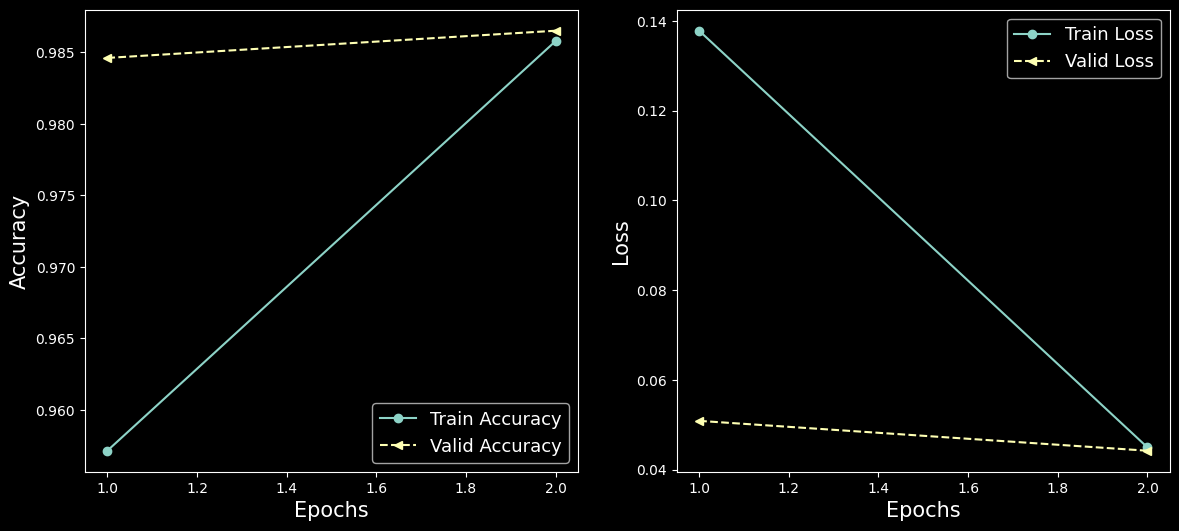

In [16]:
hist = history.history

x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Accuracy')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Valid Accuracy')
ax.set_ylabel('Accuracy', size=15)
ax.set_xlabel('Epochs', size=15)
ax.legend(fontsize=13)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Valid Loss')
ax.set_ylabel('Loss', size=15)
ax.set_xlabel('Epochs', size=15)
ax.legend(fontsize=13)

plt.show()

In [11]:
test_results = model.evaluate(test.batch(20))
print('Test Acc: {:.2f}%'.format(test_results[1] * 100))

3000/3000 [==============================] - 103s 34ms/step - loss: 0.0282 - accuracy: 0.9914
Test Acc: 99.14%


- Visual evaluate.

In [12]:
batch_test = next(iter(test.batch(12)))

preds = model(batch_test[0])
tf.print(preds.shape)

TensorShape([12, 10])


In [17]:
preds = tf.argmax(preds, axis=1)
print(preds)

tf.Tensor([4 1 0 7 8 1 2 7 1 6 6 4], shape=(12,), dtype=int64)


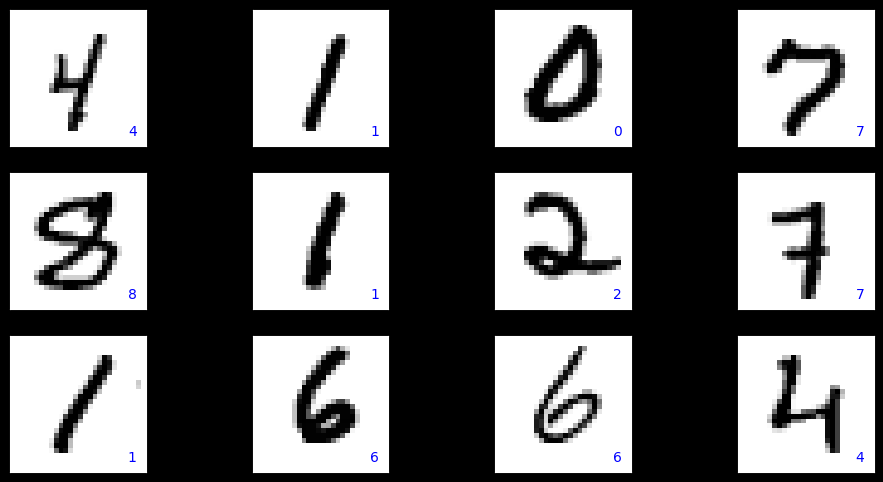

In [18]:
fig = plt.figure(figsize=(12, 6))

for i in range(12):
    ax = fig.add_subplot(3, 4, i+1)
    ax.set_xticks([]);ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), size=10, color='b',
            horizontalalignment='center', 
            verticalalignment='center',
            transform=ax.transAxes)
plt.show()